# Projekti 2: Tutustuminen Transformer-arkkitehtuuriin

## 1. Tavoiteet

Vahvista käytännössä **TRANSFORMER**-arkkitehtuurin tuntemusta toteuttamalla:

1. Tekstin luokittelu Transformer encoderin avulla
2. Kielenkääntäjä Transformerin avulla
3. Generatiivinen kielimalli Transformer-arkkitehtuurilla

## 2. Datan ymmärtäminen

In [87]:
base_path = Path('aclImdb')
splits = ['train', 'test', 'val']
categories = ['pos', 'neg']

for split in splits:
    counts = {}
    for category in categories:
        path = base_path / split / category
        counts[category] = len(list(path.glob('*.txt'))) if path.exists() else 0
    
    print(f"\n{split.capitalize()}-kansiossa:")
    for category, count in counts.items():
        print(f"- {category}: {count} tiedostoa")
    print(f"Yhteensä {split}-kansiossa: {sum(counts.values())}")


Train-kansiossa:
- pos: 16000 tiedostoa
- neg: 16000 tiedostoa
Yhteensä train-kansiossa: 32000

Test-kansiossa:
- pos: 5000 tiedostoa
- neg: 5000 tiedostoa
Yhteensä test-kansiossa: 10000

Val-kansiossa:
- pos: 4000 tiedostoa
- neg: 4000 tiedostoa
Yhteensä val-kansiossa: 8000


Aineisto on jaettu kahteen päähakemistoon: train (25 000 arvostelua), val (0 arvostelua) ja test (25 000 arvostelua), ja se sisältää 50 000 tekstitiedostoa, jotka sisältävät positiivisia ja negatiivisia elokuva-arvosteluja. Negatiiviset arvostelut (25 000 kpl) ovat neg-luetteloissa, positiiviset arvostelut (25 000 kpl) pos-luetteloissa. 

## 3. Datan esikäsittely

### 3.1 Datan esikäsittely luokitteluun Transformer encoderin avulla

Nykyinen jakautuminen:
- Koulutusjoukko: 25 000 (50%)
- Validointijoukko: 0 (0%)
- Testijoukko: 25 000 (50%)
- Kokonaiskoko: 50 000 arvostelua

Testijuokko on liian suuri. Sen vuoksi saatetaan datajoukko suhteutetuksi:
1. Koulutusjoukko: 32 000 (64%)
2. Validointijoukko: 8 000 (16%).
3. Testijoukko: 10 000 (20%)

Luodaan funktio kopioinnin tulosten tarkistamiseksi

In [88]:
def check_state():
    
    train_neg_files = len(list(Path('aclImdb/train/neg').glob('*.txt')))
    test_neg_files = len(list(Path('aclImdb/test/neg').glob('*.txt')))
    val_neg_files = len(list(Path('aclImdb/val/neg').glob('*.txt')))
    train_pos_files = len(list(Path('aclImdb/train/pos').glob('*.txt')))
    test_pos_files = len(list(Path('aclImdb/test/pos').glob('*.txt')))
    val_pos_files = len(list(Path('aclImdb/val/pos').glob('*.txt')))

    print(f"\nTrain-kansiossa:")
    print(f"- neg: {train_neg_files} tiedostoa")
    print(f"- pos: {train_pos_files} tiedostoa")
    print(f"Yhteensä train-kansiossa: {train_neg_files + train_pos_files} tiedostoa")

    print(f"\nVal-kansiossa:")
    print(f"- neg: {val_neg_files} tiedostoa")
    print(f"- pos: {val_pos_files} tiedostoa")
    print(f"Yhteensä val-kansiossa: {val_neg_files + val_pos_files} tiedostoa")

    print(f"\nTest-kansiossa:")
    print(f"- neg: {test_neg_files} tiedostoa")
    print(f"- pos: {test_pos_files} tiedostoa")
    print(f"Yhteensä test-kansiossa: {test_neg_files + test_pos_files} tiedostoa")

Kopioidann ensin negatiiviset arvostelut kansioon `train/neg`

In [89]:
import shutil

# Tarkistetaan alkutilanne
print("Alkutilanne:")

check_state()

# Kopioidaan negatiiviset arvostelut train-kansioon
copied_count = 0
train_neg_path = Path('aclImdb/train/neg')

# Koppiodaan test-kansiosta
for file in Path('aclImdb/test/neg').glob('*.txt'):
    # Luodaan uniikki nimi lisäämällä '_test' tiedoston nimeen
    new_name = file.stem + '_test' + file.suffix
    shutil.copy2(file, train_neg_path / new_name)
    file.unlink()  # Poistetaan alkuperäinen
    copied_count += 1

# Kopioidaan val-kansiosta
for file in Path('aclImdb/val/neg').glob('*.txt'):
    # Luodaan uniikki nimi lisäämällä '_val' tiedoston nimeen
    new_name = file.stem + '_val' + file.suffix
    shutil.copy2(file, train_neg_path / new_name)
    file.unlink()  # Poistetaan alkuperäinen
    copied_count += 1

# Tarkistetaan lopputilanne
print("\nKopioinnin jälkeen:")
check_state()

Alkutilanne:

Train-kansiossa:
- neg: 16000 tiedostoa
- pos: 16000 tiedostoa
Yhteensä train-kansiossa: 32000 tiedostoa

Val-kansiossa:
- neg: 4000 tiedostoa
- pos: 4000 tiedostoa
Yhteensä val-kansiossa: 8000 tiedostoa

Test-kansiossa:
- neg: 5000 tiedostoa
- pos: 5000 tiedostoa
Yhteensä test-kansiossa: 10000 tiedostoa

Kopioinnin jälkeen:

Train-kansiossa:
- neg: 24541 tiedostoa
- pos: 16000 tiedostoa
Yhteensä train-kansiossa: 40541 tiedostoa

Val-kansiossa:
- neg: 0 tiedostoa
- pos: 4000 tiedostoa
Yhteensä val-kansiossa: 4000 tiedostoa

Test-kansiossa:
- neg: 0 tiedostoa
- pos: 5000 tiedostoa
Yhteensä test-kansiossa: 5000 tiedostoa


Sitten kopioidaan positiiviset arvostelut kansioon `train/pos`

In [90]:
# Tarkistetaan alkutilanne
print("Alkutilanne:")

check_state()

# Kopioidaan posiitiviset arvostelut train-kansioon
copied_count = 0
train_pos_path = Path('aclImdb/train/pos')

# Koppiodaan test-kansiosta
for file in Path('aclImdb/test/pos').glob('*.txt'):
    # Luodaan uniikki nimi lisäämällä '_test' tiedoston nimeen
    new_name = file.stem + '_test' + file.suffix
    shutil.copy2(file, train_pos_path / new_name)
    file.unlink()  # Poistetaan alkuperäinen
    copied_count += 1

# Kopioidaan val-kansiosta
for file in Path('aclImdb/val/pos').glob('*.txt'):
    # Luodaan uniikki nimi lisäämällä '_val' tiedoston nimeen
    new_name = file.stem + '_val' + file.suffix
    shutil.copy2(file, train_pos_path / new_name)
    file.unlink()  # Poistetaan alkuperäinen
    copied_count += 1

# Tarkistetaan lopputilanne
print("\nKopioinnin jälkeen:")
check_state()

Alkutilanne:

Train-kansiossa:
- neg: 24541 tiedostoa
- pos: 16000 tiedostoa
Yhteensä train-kansiossa: 40541 tiedostoa

Val-kansiossa:
- neg: 0 tiedostoa
- pos: 4000 tiedostoa
Yhteensä val-kansiossa: 4000 tiedostoa

Test-kansiossa:
- neg: 0 tiedostoa
- pos: 5000 tiedostoa
Yhteensä test-kansiossa: 5000 tiedostoa

Kopioinnin jälkeen:

Train-kansiossa:
- neg: 24541 tiedostoa
- pos: 24512 tiedostoa
Yhteensä train-kansiossa: 49053 tiedostoa

Val-kansiossa:
- neg: 0 tiedostoa
- pos: 0 tiedostoa
Yhteensä val-kansiossa: 0 tiedostoa

Test-kansiossa:
- neg: 0 tiedostoa
- pos: 0 tiedostoa
Yhteensä test-kansiossa: 0 tiedostoa


Sitten jaetaan arvostelut kansioihin `.../neg` ja `.../pos` jakosuunnitelman mukaisesti

In [91]:
import random

# Jokaiselle kategoriolle (pos/neg)
for category in ['pos', 'neg']:
    # Kerätään kaikki tiedostot kansiosta train
    train_path = Path(f'aclImdb/train/{category}')
    files = list(train_path.glob('*.txt'))
    total_files = len(files)
    
    print(f"\nKategoria {category}:")
    print(f"Yhteensä tiedostoja: {total_files}")
    
    # Sekoitetaan tiedostot
    random.shuffle(files)
    
    # Jaetaan tiedostot val ja test -kansioihin
    test_size = int(0.2 * total_files)
    val_size = int(0.2 * (total_files-test_size))
    
    val_files = files[:val_size]
    test_files = files[val_size:val_size + test_size]
    
    # Siiretään tiedostot kansioihin
    for file in val_files:
        shutil.move(file, Path(f'aclImdb/val/{category}/{file.name}'))
    print(f"Siirretty val-kansioon: {len(val_files)}")
    
   
    for file in test_files:
        shutil.move(file, Path(f'aclImdb/test/{category}/{file.name}'))
    print(f"Siirretty test-kansioon: {len(test_files)}")
    
# Tarkastetaan montako tiedostoa jäi train-kansioon
print("\nTilanne jaon jälkeen:")
check_state()


Kategoria pos:
Yhteensä tiedostoja: 24512
Siirretty val-kansioon: 3922
Siirretty test-kansioon: 4902

Kategoria neg:
Yhteensä tiedostoja: 24541
Siirretty val-kansioon: 3926
Siirretty test-kansioon: 4908

Tilanne jaon jälkeen:

Train-kansiossa:
- neg: 15707 tiedostoa
- pos: 15688 tiedostoa
Yhteensä train-kansiossa: 31395 tiedostoa

Val-kansiossa:
- neg: 3926 tiedostoa
- pos: 3922 tiedostoa
Yhteensä val-kansiossa: 7848 tiedostoa

Test-kansiossa:
- neg: 4908 tiedostoa
- pos: 4902 tiedostoa
Yhteensä test-kansiossa: 9810 tiedostoa


### 3.2 Datan esikäsittely kielikääntäjään Transformer:n avulla

Kohdekieleksi valittiin 'russian', koska tiimissä on kaksi äidinkielenään venäjää puhuvaa henkilöä, ja näin ollen käännöksen laatua on helpompi arvioida

Tekstitiedosto sisältää yhden esimerkin rivillä: lause englannin kielellä, jota seuraa tabulaattorisymboli ja vastaava lause venäjän kielellä. Jaataan tämä tiedosto

In [92]:
text_file = "rus-eng/rus.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
    
text_pairs = []
for line in lines:
    if "\t" in line:
        english, russian = line.split("\t", 1)
        russian = russian.split("\t")[0]
        russian = "[start] " + russian + " [end]"
        text_pairs.append((english, russian))

Katsotaan, miltä `text_pairsin` sisältö näyttää

In [93]:
print(random.choice(text_pairs))

('You made a terrible mistake.', '[start] Вы совершили ужасную ошибку. [end]')


Nyt sekoitamme parit ja jaamme ne kuten tavallista koulutus-, validointi- ja testijoukoiksi:

In [94]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

## 4. Mallin rakentaminen

### 4.1 Transformer-arkkitehtuuriin perustuva luokittelumalli

In [95]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import TextVectorization

Luodaan kolme Dataset-objektia koulutus-, validointi- ja testidatoille:

In [96]:
batch_size = 32
train_ds = keras.utils.text_dataset_from_directory( 
    "aclImdb/train", batch_size=batch_size)
val_ds = keras.utils.text_dataset_from_directory( 
    "aclImdb/val", batch_size=batch_size)
test_ds = keras.utils.text_dataset_from_directory( 
    "aclImdb/test", batch_size=batch_size)

Found 31395 files belonging to 2 classes.
Found 7848 files belonging to 2 classes.
Found 9810 files belonging to 2 classes.


Suoritetaan näiden objektien esikäsittely TextVectorization-kerroksen avulla

In [97]:
# Datasetien valmistelu kokonaislukujonoilla

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization( 
    max_tokens=max_tokens, 
    output_mode="int", 
    output_sequence_length=max_length,)

text_only_train_ds = train_ds.map(lambda x, y: x)

text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map( 
    lambda x, y: (text_vectorization(x), y), 
    num_parallel_calls=4)
int_val_ds = val_ds.map( 
    lambda x, y: (text_vectorization(x), y), 
    num_parallel_calls=4)
int_test_ds = test_ds.map( 
    lambda x, y: (text_vectorization(x), y), 
    num_parallel_calls=4)

Toteutaan Transformer-kooderin Layer-luokan aliluokkana

In [98]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs): 
        super().__init__(**kwargs) 
        self.embed_dim = embed_dim 
        self.dense_dim = dense_dim 
        self.num_heads = num_heads 
        self.attention = layers.MultiHeadAttention( num_heads=num_heads, key_dim=embed_dim) 
        self.dense_proj = keras.Sequential( [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),] ) 
        self.layernorm_1 = layers.LayerNormalization() 
        self.layernorm_2 = layers.LayerNormalization() 
    

    def call(self, inputs, mask=None): 
        if mask is not None: 
            mask = mask[:, tf.newaxis, :] 
        attention_output = self.attention( inputs, inputs, attention_mask=mask) 
        proj_input = self.layernorm_1(inputs + attention_output) 
        proj_output = self.dense_proj(proj_input) 
        return self.layernorm_2(proj_input + proj_output) 


    def get_config(self): 
        config = super().get_config() 
        config.update({ 
              "embed_dim": self.embed_dim, 
              "num_heads": self.num_heads, 
              "dense_dim": self.dense_dim, }) 
        return config

Samoin toteutaan sijaintien vektoriedustuksen Layer-luokan aliluokkana

In [99]:
class PositionalEmbedding(layers.Layer): 
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs): 
        super().__init__(**kwargs) 
        self.token_embeddings = layers.Embedding( input_dim=input_dim, output_dim=output_dim) 
        self.position_embeddings = layers.Embedding( input_dim=sequence_length, output_dim=output_dim) 
        self.sequence_length = sequence_length 
        self.input_dim = input_dim 
        self.output_dim = output_dim 
    
    
    def call(self, inputs): 
        length = tf.shape(inputs)[-1] 
        positions = tf.range(start=0, limit=length, delta=1) 
        embedded_tokens = self.token_embeddings(inputs) 
        embedded_positions = self.position_embeddings(positions) 
        return embedded_tokens + embedded_positions
    
    def compute_mask(self, inputs, mask=None): 
        return tf.math.not_equal(inputs, 0)
    
    def get_config(self): 
        config = super().get_config() 
        config.update({ 
            "output_dim": self.output_dim, 
            "sequence_length": self.sequence_length, 
            "input_dim": self.input_dim, }) 
        return config

Tämän jälkeen yhdistetään Transformer-kooderin ja sijaintien vektoriedustuksen ja rakennetaan luokittelumalli

In [100]:
vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", 
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding_5 (Pos  (None, None, 256)        5273600   
 itionalEmbedding)                                               
                                                                 
 transformer_encoder_3 (Tran  (None, None, 256)        543776    
 sformerEncoder)                                                 
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                           

Luodaan callback ja koulutetaan malli

In [101]:
callbacks = [ 
    keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras", 
    save_best_only=True)]

history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)

Epoch 1/20
982/982 [==============================] - 329s 334ms/step - loss: 0.4061 - accuracy: 0.8157 - val_loss: 0.3312 - val_accuracy: 0.8578
Epoch 2/20
982/982 [==============================] - 326s 332ms/step - loss: 0.2287 - accuracy: 0.9122 - val_loss: 0.2891 - val_accuracy: 0.8940
Epoch 3/20
982/982 [==============================] - 327s 333ms/step - loss: 0.1884 - accuracy: 0.9307 - val_loss: 0.2809 - val_accuracy: 0.8962
Epoch 4/20
982/982 [==============================] - 327s 333ms/step - loss: 0.1618 - accuracy: 0.9414 - val_loss: 0.2822 - val_accuracy: 0.8931
Epoch 5/20
982/982 [==============================] - 328s 334ms/step - loss: 0.1496 - accuracy: 0.9452 - val_loss: 0.3077 - val_accuracy: 0.8865
Epoch 6/20
982/982 [==============================] - 328s 334ms/step - loss: 0.1374 - accuracy: 0.9508 - val_loss: 0.3237 - val_accuracy: 0.8890
Epoch 7/20
982/982 [==============================] - 326s 332ms/step - loss: 0.1273 - accuracy: 0.9552 - val_loss: 0.3011 -

Visualisoidaan tulokset

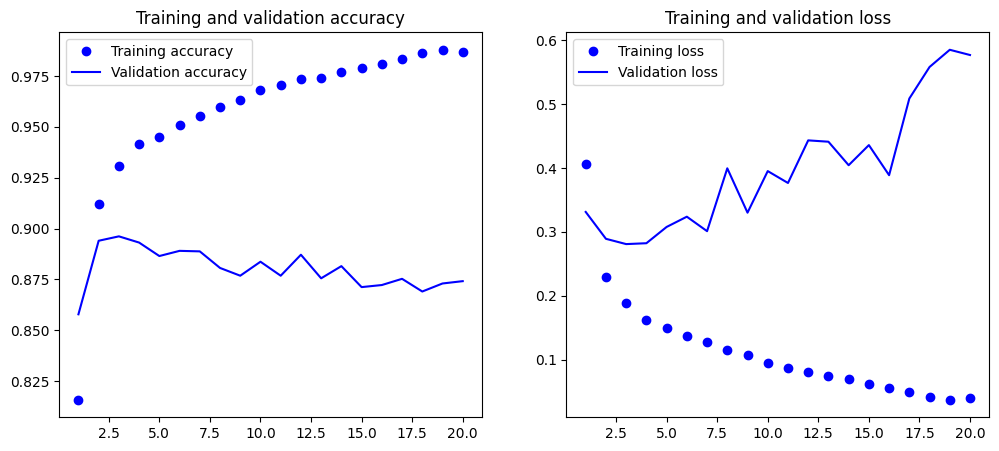

In [102]:
import matplotlib.pyplot as plt
# Visualisoidaan koulutus- ja validointitulokset
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


axes[0].plot(epochs, accuracy, "bo", label="Training accuracy")
axes[0].plot(epochs, val_accuracy, "b", label="Validation accuracy")
axes[0].set_title("Training and validation accuracy")
axes[0].legend()


axes[1].plot(epochs, loss, "bo", label="Training loss")
axes[1].plot(epochs, val_loss, "b", label="Validation loss")
axes[1].set_title("Training and validation loss")
axes[1].legend()

Arvioidaan luokittelumallin tehokkuuden testijoukon avulla

In [103]:
model = keras.models.load_model( "full_transformer_encoder.keras", custom_objects={"TransformerEncoder": TransformerEncoder, "PositionalEmbedding": PositionalEmbedding})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

307/307 [==============================] - 35s 115ms/step - loss: 0.2890 - accuracy: 0.8984
Test acc: 0.898


#### Johtopäätös:

Malli saavutti `89,5 %` tarkkuuden testidatassa, mikä on vakava tulos, joka osoittaa, että `Transformer`-arkkitehtuurin ja sanojen järjestystiedon (`PositionalEmbedding`) avulla tekstin luokittelussa voidaan saavuttaa korkea tarkkuus

### 4.2 Kielenkääntäjä Transformerin avulla

Valmistelu merkkijonojen standardointifunktiolle TextVectorization-kerrokselle, joka käsittelee tekstiä ja säilyttää hakasulut [ ja ]

In [104]:
import string
import re

strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string) 
    return tf.strings.regex_replace( lowercase, f"[{re.escape(strip_chars)}]", "")

Seuraavaksi valmistetaan kaksi erillistä TextVectorization-kerrosta: yhden englannin kielelle ja yhden venäjän kielelle

In [105]:
vocab_size = 15000
sequence_length = 20

source_vectorization = layers.TextVectorization( 
    max_tokens=vocab_size, 
    output_mode="int", 
    output_sequence_length=sequence_length,)

target_vectorization = layers.TextVectorization( 
    max_tokens=vocab_size, 
    output_mode="int", 
    output_sequence_length=sequence_length + 1, 
    standardize=custom_standardization,)

train_english_texts = [pair[0] for pair in train_pairs]
train_russian_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_russian_texts)

Seuraavaksi valmistetaan datasetit konekäännöstehtävälle

In [106]:
batch_size = 64
def format_dataset(eng, rus):
     eng = source_vectorization(eng) 
     rus = target_vectorization(rus) 
     return ({ 
          "english": eng, 
          "russian": rus[:, :-1], },
            rus[:, 1:])


def make_dataset(pairs): 
    eng_texts, rus_texts = zip(*pairs) 
    eng_texts = list(eng_texts) 
    rus_texts = list(rus_texts) 
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, rus_texts)) 
    dataset = dataset.batch(batch_size) 
    dataset = dataset.map(format_dataset, num_parallel_calls=4) 
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

Tarkistetaan, miltä datasetit näyttävät

In [107]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['russian'].shape: {inputs['russian'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['russian'].shape: (64, 20)
targets.shape: (64, 20)


Samoin kuin `TransformerEncoder` -tapauksessa, toteutetaan oma aliluoka `TransformerDecoder` Layer-luokasta

In [108]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs) 

        self.embed_dim = embed_dim 
        self.dense_dim = dense_dim 
        self.num_heads = num_heads 

        self.attention_1 = layers.MultiHeadAttention( 
            num_heads=num_heads, 
            key_dim=embed_dim) 
        
        self.attention_2 = layers.MultiHeadAttention( 
            num_heads=num_heads, 
            key_dim=embed_dim) 
        
        self.dense_proj = keras.Sequential( 
            [layers.Dense(dense_dim, activation="relu"), 
             layers.Dense(embed_dim),] ) 
        
        self.layernorm_1 = layers.LayerNormalization() 
        self.layernorm_2 = layers.LayerNormalization() 
        self.layernorm_3 = layers.LayerNormalization() 
        self.supports_masking = True 
    
    def get_config(self): 
        config = super().get_config() 
        config.update({ 
            "embed_dim": self.embed_dim, 
            "num_heads": self.num_heads, 
            "dense_dim": self.dense_dim, }) 
        return config
    
    def get_causal_attention_mask(self, inputs): 
        input_shape = tf.shape(inputs) 
        batch_size, sequence_length = input_shape[0], input_shape[1] 
        i = tf.range(sequence_length)[:, tf.newaxis] 
        j = tf.range(sequence_length) 
        mask = tf.cast(i >= j, dtype="int32") 
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat( 
            [tf.expand_dims(batch_size, -1), 
             tf.constant([1, 1], dtype=tf.int32)], axis=0) 
        return tf.tile(mask, mult)
    
    def call(self, inputs, encoder_outputs, mask=None): 
        causal_mask = self.get_causal_attention_mask(inputs) 
        if mask is not None: 
            padding_mask = tf.cast( mask[:, tf.newaxis, :], dtype="int32") 
            padding_mask = tf.minimum(padding_mask, causal_mask) 
            attention_output_1 = self.attention_1( 
                query=inputs, 
                value=inputs, 
                key=inputs, 
                attention_mask=causal_mask) 
            
            attention_output_1 = self.layernorm_1(inputs + attention_output_1) 

            attention_output_2 = self.attention_2(
                query=attention_output_1, 
                value=encoder_outputs, 
                key=encoder_outputs, 
                attention_mask=padding_mask,) 
            
            attention_output_2 = self.layernorm_2( attention_output_1 + attention_output_2) 

            proj_output = self.dense_proj(attention_output_2) 
            
            return self.layernorm_3(attention_output_2 + proj_output)

Yhdistetään kaikki yhteen: Transformer-malli konekäännökseen  
Päästä päähän -Transformer-malli on malli, jota aiotaan kouluttaa. Se muuntaa alkuperäisen ja kohdeperiaatteen kohdeperiaatteeksi, joka on yhden askeleen tulevaisuudessa. Päästä päähän -malli yhdistää osat, jotka ollaan luoneet tähän mennessä: PositionalEmbedding-kerrokset, TransformerEncoder ja TransformerDecoder.

In [85]:
# TransformerDecoder-mallin rakentaminen
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)

encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="russian")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

Transformer-mallin kouluttaminen

In [86]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
transformer.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
5426/5426 [==============================] - 1346s 248ms/step - loss: 1.2443 - accuracy: 0.5409 - val_loss: 1.0055 - val_accuracy: 0.6132
Epoch 2/30
5426/5426 [==============================] - 1332s 245ms/step - loss: 1.0182 - accuracy: 0.6196 - val_loss: 0.9513 - val_accuracy: 0.6435
Epoch 3/30
5426/5426 [==============================] - 1339s 247ms/step - loss: 0.9842 - accuracy: 0.6433 - val_loss: 0.9283 - val_accuracy: 0.6589
Epoch 4/30
5426/5426 [==============================] - 1367s 252ms/step - loss: 0.9610 - accuracy: 0.6563 - val_loss: 0.9121 - val_accuracy: 0.6649
Epoch 5/30
5426/5426 [==============================] - 1347s 248ms/step - loss: 0.9402 - accuracy: 0.6655 - val_loss: 0.9018 - val_accuracy: 0.6681
Epoch 6/30
5426/5426 [==============================] - 1368s 252ms/step - loss: 0.9220 - accuracy: 0.6727 - val_loss: 0.8851 - val_accuracy: 0.6761
Epoch 7/30
5426/5426 [==============================] - 1348s 248ms/step - loss: 0.9068 - accuracy: 0.6787

Sovelletaan malli englanninkielisten lauseiden kääntämiseen testijoukosta

In [110]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence): 
    tokenized_input_sentence = source_vectorization([input_sentence]) 
    decoded_sentence = "[start]" 
    for i in range(max_decoded_sentence_length): 
        tokenized_target_sentence = target_vectorization( [decoded_sentence])[:, :-1] 
        predictions = transformer( [tokenized_input_sentence, tokenized_target_sentence]) 
        sampled_token_index = np.argmax(predictions[0, i, :]) 
        sampled_token = spa_index_lookup[sampled_token_index] 
        decoded_sentence += " " + sampled_token 
        if sampled_token == "[end]": 
            break 
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20): 
    input_sentence = random.choice(test_eng_texts) 
    print("-") 
    print(input_sentence) 
    print(decode_sequence(input_sentence))

-
You have no idea who I am, do you?
[start] Ты не [UNK] кто я не так раз [end]
-
It's an excellent idea.
[start] Это [UNK] [UNK] [end]
-
Is Tom young?
[start] Том не [UNK] [end]
-
I guess I'm just tired.
[start] Я [UNK] так [UNK] [end]
-
Is that your boy?
[start] Это рад ту [end]
-
Do you want to know the truth?
[start] Ты [UNK] были да [end]
-
When I'm with you, I'm happy.
[start] Если ты [UNK] [end]
-
Daddy, let's have a staring contest.
[start] [UNK] есть [UNK] [UNK] [end]
-
How did you spend your winter vacation?
[start] нас вы нужна [UNK] на свои [UNK] [end]
-
Children like climbing trees.
[start] Не нужна Тому вы Вас [UNK] [end]
-
Do you have any family or friends you could stay with?
[start] Ты [UNK] [UNK] [UNK] [UNK] [end]
-
I'm a little taller than my father.
[start] Я не [UNK] Тому [UNK] в нашёл сахара [end]
-
There's no one like Tom.
[start] У тебе в начал проблема нет Том [end]
-
The only time my son talks to me is when he needs some money.
[start] Если сейчас [UNK] перед 

#### Johtopäätös:

Äidinkielenään venäjää puhuvana huomauttaisin, että käännös on kaukana täydellisestä, mutta on tärkeää ottaa huomioon, että mallin koulutusta voitaisiin jatkaa, koska tulosten perusteella tarkkuus validointijoukossa jatkoi kasvuaan, mikäli käytössä olisi tehokkaampi tietokone. Koulutus 30 epochin ajan kesti noin 12 tuntia

### 4.3 Generatiivinen kielimalli Transformer-arkkitehtuurilla

Seuraavaksi toteutaan malli, joka pystyy generoimaan uusia elokuva-arvosteluja. Koulutus- ja validointidatasetina käytetään sama datasetti, jota käytettiin luokittelumallin luomiseen

Datasetin luominen tekstitiedostoista (yksi tiedosto = yksi esimerkki)

In [111]:
dataset = keras.utils.text_dataset_from_directory( 
    directory="aclImdb", 
    label_mode=None, 
    batch_size=256)
dataset = dataset.map(lambda x: tf.strings.regex_replace(x, "<br />", " "))

Found 49053 files belonging to 1 classes.


Nyt käytetään TextVectorization-kerrosta sanaston luomiseen, jonka kanssa työskentellään. Poimitaan jokaisesta arvostelusta vain ensimmäiset sequence_length sanaa: TextVectorization-kerros leikkaa kaiken muun tekstin vektorisoinnin aikana

In [112]:
sequence_length = 100
vocab_size = 15000

text_vectorization = TextVectorization( 
    max_tokens=vocab_size, 
    output_mode="int", 
    output_sequence_length=sequence_length,)

text_vectorization.adapt(dataset)

Luodaan datasetti kielimallille, jossa syöte-esimerkit ovat vektoroituja tekstin osia ja vastaavat kohteet ovat samat osat, mutta siirretty yhden sanan verran

In [117]:
def prepare_lm_dataset(text_batch): 
    vectorized_sequences = text_vectorization(text_batch) 
    x = vectorized_sequences[:, :-1] 
    y = vectorized_sequences[:, 1:] 
    return x, y

lm_dataset = dataset.map(prepare_lm_dataset, num_parallel_calls=4)

Sitten toteutetaan malli. Tätä varten käytetään uudelleen `PositionalEmbedding`- ja `TransformerDecoder`-luokat

In [113]:
layersembed_dim = 256
latent_dim = 2048
num_heads = 2
inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, x)
outputs = layers.Dense(vocab_size, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop")

Tekstin generoimiseksi eri lämpötiloilla käytetään callbackit jokaisen aikajakson jälkeen. Tämä mahdollistaa tarkastella, miten generoitu teksti muuttuu mallin lähestyessä konvergenssia, sekä miten lämpötila vaikuttaa valintastrategiaan. Tekstin generaatiota varten käytetään vihje 'this movie': kaikki generoima tekstit alkavat tästä lausekkeesta

In [114]:
tokens_index = dict(enumerate(text_vectorization.get_vocabulary()))
def sample_next(predictions, temperature=1.0): 
    predictions = np.asarray(predictions).astype("float64") 
    predictions = np.log(predictions) / temperature 
    exp_preds = np.exp(predictions) 
    predictions = exp_preds / np.sum(exp_preds) 
    probas = np.random.multinomial(1, predictions, 1) 
    return np.argmax(probas)

class TextGenerator(keras.callbacks.Callback): 
    def __init__(self, 
                 prompt, 
                 generate_length, 
                 model_input_length, 
                 temperatures=(1.,), 
                 print_freq=1): 
        self.prompt = prompt
        self.generate_length = generate_length 
        self.model_input_length = model_input_length 
        self.temperatures = temperatures 
        self.print_freq = print_freq 
    
    def on_epoch_end(self, epoch, logs=None): 
        if (epoch + 1) % self.print_freq != 0: 
            return 
        for temperature in self.temperatures: 
            print("== Generating with temperature", temperature) 
            sentence = self.prompt 
            for i in range(self.generate_length): 
                tokenized_sentence = text_vectorization([sentence]) 
                predictions = self.model(tokenized_sentence) 
                next_token = sample_next(predictions[0, i, :]) 
                sampled_token = tokens_index[next_token] 
                sentence += " " + sampled_token 
                print(sentence)



In [115]:
prompt = "This movie"
text_gen_callback = TextGenerator( prompt, 
                                  generate_length=50, 
                                  model_input_length=sequence_length, 
                                  temperatures=(0.2, 0.5, 0.7, 1., 1.5))

Nyt koulutataan mall

In [118]:
model.fit(lm_dataset, epochs=50, callbacks=[text_gen_callback])

Epoch 1/50
192/192 [==============================] - ETA: 0s - loss: 5.5939== Generating with temperature 0.2
This movie movie
This movie movie has
This movie movie has was
This movie movie has was the
This movie movie has was the pretty
This movie movie has was the pretty script
This movie movie has was the pretty script good
This movie movie has was the pretty script good ive
This movie movie has was the pretty script good ive to
This movie movie has was the pretty script good ive to seen
This movie movie has was the pretty script good ive to seen be
This movie movie has was the pretty script good ive to seen be in
This movie movie has was the pretty script good ive to seen be in a
This movie movie has was the pretty script good ive to seen be in a expectations
This movie movie has was the pretty script good ive to seen be in a expectations small
This movie movie has was the pretty script good ive to seen be in a expectations small and
This movie movie has was the pretty script good

#### Johtopäätös:

Alhaisen lämpötilan arvolla generoituu melko ennustettavaa ja toistuvaa tekstiä, ja joskus generaatioprosessi vain jää jumittamaan. Korkean lämpötilan arvolla syntyy mielenkiintoisempaa tekstiä, mutta lauseen sisäinen rakenne alkaa hajota ja teksti näyttää satunnaiselta sanajoukolta.
On syytä huomioida, että kouluttamalla suurempaa mallia pidempään ja suuremmalla tietomäärällä voidaan saavuttaa realistisemman näköistä tekstiä. Kuitenkin ei kannata kuvitella, että tämä olisi järkevää tekstiä, ainakaan muuta kuin satunnaisesti ja sinun henkilökohtaisen tulkintasi mukaan: näytteitä valitaan vain tilastollisesta mallista, jossa sanat seuraavat toisiaan

## 5. Arviointi

#### 5.1 Transformer-arkkitehtuuriin perustuva luokittelumalli

Malli saavutti `89,5 %` tarkkuuden testidatassa, mikä on vakava tulos, joka osoittaa, että `Transformer`-arkkitehtuurin ja sanojen järjestystiedon (`PositionalEmbedding`) avulla tekstin luokittelussa voidaan saavuttaa korkea tarkkuus. Все же модель может уступать моделям `bag of words`. 

Uuden tekstin luokittelutehtävän aloittaessasi on tärkeää kiinnittää huomiota koulutusdatassa olevien näytteiden määrän ja keskimääräisen sanamäärän suhteeseen näytteessä. Jos tämä suhde on alle 1500, on parempi käyttää bigrammi-taskumallia (lisäksi se oppii ja suorittaa iteraatioita huomattavasti nopeammin). Jos suhde on yli 1500, tulisi käyttää sekvenssimallia. Toisin sanoen sekvenssimallit toimivat paremmin, kun koulutusdataa on runsaasti ja näytteet ovat suhteellisen lyhyitä

#### 5.2 Kielenkääntäjä Transformerin avulla

Transformerin avulla toteutetun kääntäjän myötä saatiin varsin hyviä tuloksia (ottaen huomioon rajatun tietojoukon ja mallin kouluttamiseen käytettävissä olevat vähäiset resurssit). 'Sekvenssi-sisekvenssi' -koulutus on yleinen ja voimakas lähestymistapa, jota voidaan soveltaa moniin luonnollisen kielen käsittelyn tehtäviin, mukaan lukien konekäännös. Malli koostuu kahdesta komponentista: enkooderista, joka käsittelee alkuperäistä sekvenssiä, ja dekooderista, joka yrittää ennakoida tulevia tokeneita kohdesekvenssissä tarkastelemalla edellisiä tokeneita, jotka enkooderi on saanut alkuperäisestä sekvenssistä.

#### 5.3 Generatiivinen kielimalli Transformer-arkkitehtuurilla

Generatiivinen kielimalli Transformer-arkkitehtuurilla on osoittanut melko hyviä tuloksia (ottaen huomioon tämän työn käytettyjen syötteiden rajallisuus). On myös syytä huomata, että tärkeä näkökohta generaatioprosessissa on entropian suuruus (tässä työssä käytämme termiä 'lämpötila'). Mitä korkeampi lämpötila, sitä enemmän seuraavan tokenin valinnan tasapaino mallin mielipiteen ja satunnaisuuden välillä siirtyy satunnaisuuden puolelle. Korkeat lämpötilat voivat johtaa lauseen rakenteen täydelliseen romuttumiseen, ja teksti muistuttaa satunnaisia sanoja. Näin tai näin, malli kuitenkin käyttää annettuja tietoja generaatioprosessissa, eikä se luo järkevää tekstiä

## 6. Yhteenveto

- **Transformer-arkkitehtuuri**, joka koostuu **TransformerEncoderista** ja **TransformerDecoderista**, antaa erinomaisia tuloksia sekvenssien muunnostehtävissä. Ensimmäistä osaa (**TransformerEncoderia**) voidaan myös käyttää tekstin luokitteluun tai mihin tahansa muuhun luonnollisen kielen käsittelytehtävään, jossa on yksi syöte

- **Tekstin luokittelu Transformer-enkooderin avulla**: Tämä mahdollisti syvemmän ymmärryksen siitä, miten Transformer-arkkitehtuuria voidaan soveltaa tekstidatan käsittelyyn ja luokitteluun. Esitetty lähestymistapa osoitti korkean tarkkuuden luokittelussa, mikä vahvistaa tämän arkkitehtuurin tehokkuuden.

- **Kielenkääntäjä Transformerin avulla**: Konekäännöksen toteutus osoitti, kuinka Transformer mahdollistaa monimutkaisempien kielimuunnosten toteuttamisen säilyttäen tekstin syntaktisen ja semanttisen eheyden.

- **Generatiivinen kielimalli Transformer-arkkitehtuurilla**: Yhteenvetona, generatiivisen kielimallin luominen vahvisti, että Transformer ei ainoastaan sovellu tekstin analysoimiseen ja ymmärtämiseen, vaan se kykenee myös tuottamaan mielekkäitä tekstikappaleita (riittävän tietomäärän ollessa olemassa). Tämä avaa uusia horisontteja generatiivisten mallien käytölle eri sovelluksissa, aina sisällön kirjoittamisesta dialogijärjestelmien luomiseen.

Näin ollen työ osoitti **TRANSFORMER**-arkkitehtuurin monipuolisuuden ja voimakkuuden eri luonnollisen kielen käsittelyn tehtävissä, mikä tekee siitä tärkeän työkalun nykyaikaisessa koneoppimisessa ja tekoälyn toteutamassa